# Exploration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Input

In [2]:
from sklearn.datasets import load_files

raw_corpus = load_files("../data/", shuffle=False)

In [3]:
doc_count = len(raw_corpus.data)
print("Doc count:", doc_count)
assert doc_count is 56, "Wrong number of documents loaded, should be 56 (56 stories)"

Doc count: 56


In [4]:
print("Beginning:\n", raw_corpus.data[0][:500], "\n")
print("End:\n", raw_corpus.data[0][-200:])

Beginning:
 b"\n\n\n\n                                  HIS LAST BOW\n\n                         An Epilogue of Sherlock Holmes\n\n                               Arthur Conan Doyle\n\n\n\n     It was nine o'clock at night upon the second of August--the most\n     terrible August in the history of the world. One might have thought\n     already that God's curse hung heavy over a degenerate world, for\n     there was an awesome hush and a feeling of vague expectancy in the\n     sultry and stagnant air. The sun had long set, b" 

End:
 b' her up, Watson, for it\'s time that\n     we were on our way. I have a check for five hundred pounds which\n     should be cashed early, for the drawer is quite capable of stopping\n     it if he can."\n\n'


## Baseline

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents="ascii", lowercase=True)
X = tfidf.fit_transform(raw_corpus.data)

In [6]:
print(len(tfidf.get_feature_names()))
X.shape

15875


(56, 15875)

In [7]:
#tfidf.get_feature_names()

## Preparation

In [8]:
# Custom wrangler
from tokenizer import TextWrangler

[nltk_data] Downloading package punkt to ../nltk/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../nltk/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ../nltk/...
[nltk_data]   Package wordnet is already up-to-date!


## Vectorizer

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_pure = CountVectorizer(strip_accents="ascii", lowercase=True, stop_words=None)
X_bow_pure = bow_pure.fit_transform(raw_corpus.data)

bow_stem = CountVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="stem"))
X_bow_stem = bow_stem.fit_transform(raw_corpus.data)

tfidf_stem = TfidfVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="stem"))
X_tfidf_stem = tfidf_stem.fit_transform(raw_corpus.data)

bow_lemma = CountVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="lemma"))
X_bow_lemma = bow_lemma.fit_transform(raw_corpus.data)

tfidf_lemma = TfidfVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="lemma"))
X_tfidf_lemma = tfidf_lemma.fit_transform(raw_corpus.data)

In [10]:
print("Pure bow vector:", X_bow_pure.shape)
print(bow_pure.get_feature_names()[:10], "...")
print("Stemmed bow vector:", X_bow_stem.shape)
print(bow_stem.get_feature_names()[:10], "...")
print("Lemmatized bow vector:", X_bow_lemma.shape)
print(bow_lemma.get_feature_names()[:10], "...")
print("Stemmed tfidf vector:", X_tfidf_stem.shape)
print(tfidf_stem.get_feature_names()[:10], "...")
print("Lemmatized tfidf vector:", X_tfidf_lemma.shape)
print(tfidf_lemma.get_feature_names()[:10], "...")

Pure bow vector: (56, 15875)
['000', '10', '100', '1000', '104', '10s', '10th', '11', '1100', '117'] ...
Stemmed bow vector: (56, 8266)
['NUM', 'ab', 'aback', 'abandon', 'abba', 'abbess', 'abbey', 'abbot', 'abduc', 'aber'] ...
Lemmatized bow vector: (56, 13735)
['NUM', 'aback', 'abandon', 'abandoned', 'abandoning', 'abated', 'abbas', 'abbess', 'abbey', 'abbot'] ...
Stemmed tfidf vector: (56, 8266)
['NUM', 'ab', 'aback', 'abandon', 'abba', 'abbess', 'abbey', 'abbot', 'abduc', 'aber'] ...
Lemmatized tfidf vector: (56, 13735)
['NUM', 'aback', 'abandon', 'abandoned', 'abandoning', 'abated', 'abbas', 'abbess', 'abbey', 'abbot'] ...


# Vectors

## Ranking

In [11]:
# Ranking word patterns
def rank(features, values, metric):
    data = []
    for col, term in enumerate(features):
        data.append((term, values[0, col]))

    df = pd.DataFrame(data, columns=["term", metric])
    order = df.sort_values(metric, ascending=False)
    order.reset_index(drop=True, inplace=True)
    order.index = order.index + 1
    return order

In [12]:
assert bow_stem.get_feature_names() == tfidf_stem.get_feature_names(), "Mismatch of stem feature names (->tokenize)"
assert bow_lemma.get_feature_names() == tfidf_lemma.get_feature_names(), "Mismatch of lemma feature names (->tokenize)"
stem_features = bow_stem.get_feature_names()
lemma_features = bow_lemma.get_feature_names()
pure_features = bow_pure.get_feature_names()

bow_stem_sum = X_bow_stem.sum(axis=0)
bow_lemma_sum = X_bow_lemma.sum(axis=0)
bow_pure_sum = X_bow_pure.sum(axis=0)

tfidf_stem_mean = X_tfidf_stem.mean(axis=0)
tfidf_lemma_mean = X_tfidf_lemma.mean(axis=0)

In [13]:
bow_stem_ranked = rank(stem_features, bow_stem_sum, "bow_sum") 
bow_lemma_ranked = rank(lemma_features, bow_lemma_sum, "bow_sum")
bow_pure_ranked = rank(pure_features, bow_pure_sum, "bow_sum")

print("BOW Pure:\n", bow_pure_ranked.head(15), "\n")
print("BOW Stem:\n", bow_stem_ranked.head(15), "\n")
print("BOW Lemma:\n", bow_lemma_ranked.head(15))

BOW Pure:
     term  bow_sum
1    the    24569
2    and    11938
3     of    11283
4     to    11090
5   that     7944
6     it     7628
7     in     7499
8     he     7003
9    was     6984
10   you     6716
11   his     5294
12    is     4746
13   had     4151
14  have     3924
15    my     3895 

BOW Stem:
      term  bow_sum
1     com      965
2    hand      895
3    room      891
4    know      820
5    look      761
6   littl      749
7     tim      731
8     fac      721
9   think      690
10   hous      655
11    cas      634
12   door      631
13    let      620
14    way      620
15    cam      613 

BOW Lemma:
       term  bow_sum
1     room      888
2     hand      808
3     come      807
4     know      781
5   little      749
6     time      727
7     face      663
8    house      655
9    think      653
10    door      631
11    case      626
12     way      620
13    came      611
14     sir      593
15     day      582


In [14]:
tfidf_stem_ranked = rank(stem_features, tfidf_stem_mean, "tfidf_mean") 
tfidf_lemma_ranked = rank(lemma_features, tfidf_lemma_mean, "tfidf_mean")

print("TFIDF Stem:\n", tfidf_stem_ranked.head(15), "\n")
print("TFIDF Lemma:\n", tfidf_lemma_ranked.head(15))

TFIDF Stem:
      term  tfidf_mean
1     com    0.072029
2    room    0.067702
3    hand    0.066507
4    know    0.062388
5    look    0.056854
6   littl    0.056025
7     tim    0.054707
8     fac    0.054141
9   think    0.051839
10   hous    0.050586
11   door    0.048686
12    cas    0.047255
13    let    0.046725
14    way    0.046319
15    cam    0.046165 

TFIDF Lemma:
       term  tfidf_mean
1     room    0.064978
2     come    0.058276
3     hand    0.057682
4     know    0.057000
5   little    0.054046
6     time    0.052318
7    house    0.048667
8     face    0.048149
9    think    0.047183
10    door    0.046849
11    case    0.044865
12     way    0.044505
13    came    0.044302
14     sir    0.042153
15     day    0.041662


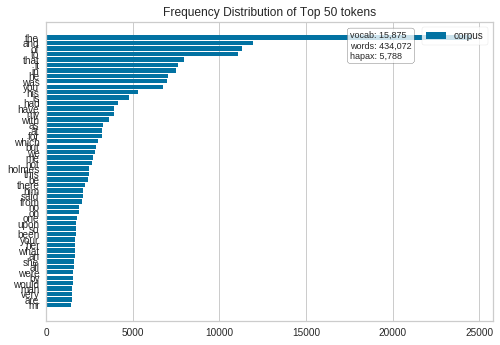

In [15]:
from yellowbrick.text.freqdist import FreqDistVisualizer

visualizer = FreqDistVisualizer(features=pure_features)
visualizer.fit(X_bow_pure)
visualizer.poof()

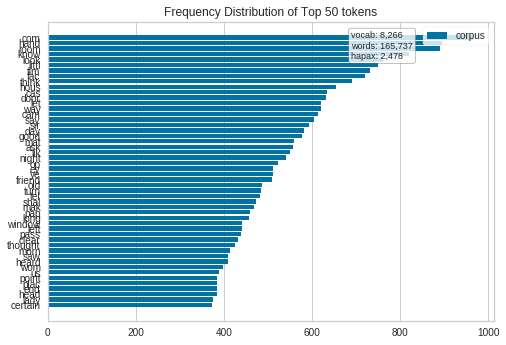

In [16]:
visualizer = FreqDistVisualizer(features=stem_features)
visualizer.fit(X_bow_stem)
visualizer.poof()

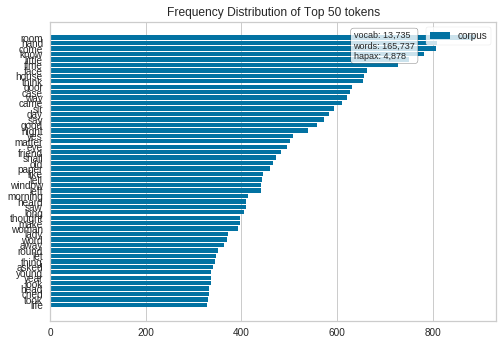

In [17]:
visualizer = FreqDistVisualizer(features=lemma_features)
visualizer.fit(X_bow_lemma)
visualizer.poof()

## Distribution

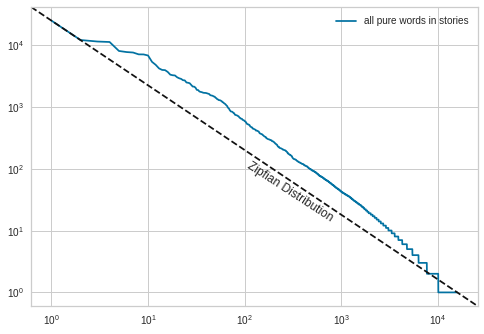

In [18]:
p_df = bow_pure_ranked
p_df.columns = [_, "all pure words in stories"]

ax = p_df.plot(loglog=True)
ax.annotate("Zipfian Distribution", (100, 100), rotation=-33)
plt.plot([0, 1], [1, 0], transform=ax.transAxes, ls="--", c="k")

Stemming vs Lemma

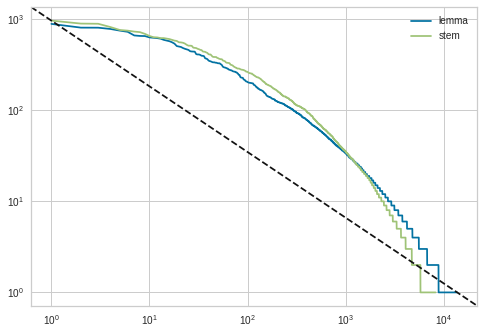

In [19]:
p_df1 = bow_lemma_ranked
p_df1.columns = [_, "lemma"]
p_df2 = bow_stem_ranked
p_df2.columns = [_, "stem"]

ax = p_df1.plot(loglog=True)
p_df2.plot(loglog=True, ax=ax)
plt.plot([0, 1], [1, 0], transform=ax.transAxes, ls="--", c="k")

## t-SNE

In [20]:
collections_map = {0: "His_Last_Bow", 1: "The_Adventures_of_Sherlock_Holmes",
                   2: "The_Case-Book_of_Sherlock_Holmes", 3: "The_Memoirs_of_Sherlock_Holmes",
                   4: "The_Return_of_Sherlock_Holmes"}
labels = [collections_map.get(item, item) for item in raw_corpus.target]

Stemmed Tf-idf Vectors

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

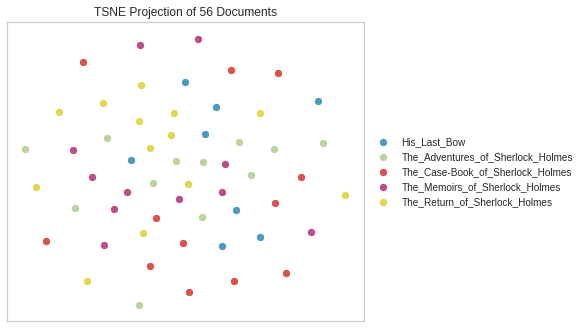

In [21]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(X_tfidf_stem, labels)
tsne.poof()

Lemmatized Tf-idf Vectors

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

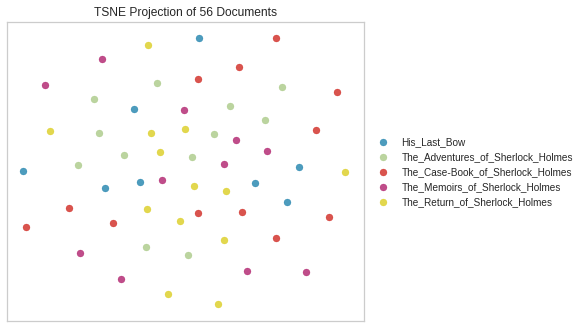

In [22]:
tsne = TSNEVisualizer()
tsne.fit(X_tfidf_lemma, labels)
tsne.poof()